### 패키지 설치 및 임포트

In [1]:
# pip install pandas
# pip install matplotlib
# pip install scikit-learn
# pip install tensorflow
# pip install nltk

In [3]:
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import re
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
import nltk

### 데이터 불러와서 df 변환

In [101]:
def read_json_to_df(file_path):
    try:
        # JSON 파일을 DataFrame으로 읽어오기
        df = pd.read_json(file_path)
        return df
    except FileNotFoundError:
        print("File not found.")
        return None

# JSON 파일 경로 설정
json_file_path_1 = 'category/article(0308).json'
json_file_path_2 = 'category/article(0319).json'
json_file_path_3 = 'category/article(0324).json'

# JSON 파일을 DataFrame으로 변환하여 출력
df1 = read_json_to_df(json_file_path_1)
df1.drop(df1[(df1['category'] == 'us') | (df1['category'] == 'world')].index, inplace=True)

df2 = read_json_to_df(json_file_path_2)
df3 = read_json_to_df(json_file_path_3)

df = pd.concat([df1, df2, df3]).drop_duplicates(subset='title', keep='first')
if df is not None:
    print(df)

                                                 title  category  \
97                   3 very different border realities  politics   
98   Biden directs US military to establish aid por...  politics   
99   Jill Biden’s State of the Union guests include...  politics   
100  Supreme Court is under pressure to step into t...  politics   
101  Biden projects a vision of strength that’s bee...  politics   
..                                                 ...       ...   
300  No perfect brackets remaining in men’s March M...    sports   
302  Sven-Göran Eriksson reflects on his terminal c...    sports   
303  MLB launches investigation into allegations ar...    sports   
304  Inter Milan player Francesco Acerbi leaves Ita...    sports   
305  Tennis stars voice support for Aryna Sabalenka...    sports   

                                                  text  
97   Three completely different border realities we...  
98   As President Joe Biden addressed Congress and ...  
99   An Alab

## 데이터 증강 해보기

In [ ]:
# pip install numpy requests nlpaug

In [48]:
import nlpaug.augmenter.word as naw

In [138]:
# 라벨 분포 분석
categories = df['category'].value_counts().reset_index()
categories.columns = ['category', 'count']

# 결과 출력
print(categories)


        category  count
0       politics    138
1       business    124
2         sports    108
3          style     98
4  entertainment     86
5         health     76
6         travel     72


In [144]:
import numpy as np
from nltk.corpus import wordnet
import nlpaug.augmenter.word as naw

# 데이터 증강
def augment_data(text):
    aug = naw.SynonymAug()
    augmented_text = aug.augment(text, n=1)
    return augmented_text[0]

augment_data(df.iloc[0]['text'])

['Three completely different border realities were displayed Thursday. ► There ’ s the Donald Trump reality, where President Joe Biden is to blame and a military force is needed to shut the border, control an invasion of “ murderers, ” round up the undocumented and expel them from the US. ► There ’ s the Biden reality, where Trump is to blame for killing a bipartisan compromise that would have given all president of the united states new powers to control the influx of migrants and streamline a broken asylum process. ► And there ’ s the lived reality of children and family facing hunger and hypothermia in open - air camps along the border. That grim picture was presented in court filings related to the camps near the US - Mexico border in California, which seek to force the federal government to better protect the well - being of people who are waiting to make asylum claims. Read CNN ’ s report, which includes images of a girl in a cast deposited at an open - air camp and a woman trapp

In [146]:
# 카테고리 별 기사 개수 200개 혹은 2배로 늘리기
def make_data(target_category):
    filtered_df = df[df['category'] == target_category]

    target_cnt = min(200 - len(filtered_df), len(filtered_df))
    
    target_row = filtered_df.sample(n=target_cnt)

    for idx, ori in target_row.iterrows():
        new_row = pd.DataFrame({'title': ori['title'], 'category': ori['category'], 'text': augment_data(ori['text'])})
        filtered_df = pd.concat([filtered_df, new_row])
    return filtered_df

aug_df = pd.DataFrame()
for cat in categories['category']:
    aug_df = pd.concat([aug_df, make_data(cat)])

len(aug_df)

1263

### 기사 텍스트 데이터 클리닝

In [147]:
from nltk.tokenize import RegexpTokenizer

def make_lower_case(text):
    return text.lower()

# 구두문자 제거
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

aug_df['cleaned_text'] = aug_df.text.apply(make_lower_case)
aug_df['cleaned_text'] = aug_df.cleaned_text.apply(remove_punctuation)

aug_df['cleaned_text']

97     three completely different border realities we...
98     as president joe biden addressed congress and ...
99     an alabama woman seeking in vitro fertilizatio...
100    the supreme court is facing intense pressure t...
101    this version of joe biden could beat donald tr...
                             ...                        
0      as they walked through the stunning palazzo an...
0      when napoleon first encountered a camembert ch...
0      long lines feeling bleary eyed and exhausted a...
0      guillermo barrantes relationship with larry mo...
0      ed pierson was flying from seattle to new jers...
Name: cleaned_text, Length: 1263, dtype: object

## 모델 훈련

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

### 데이터셋 로드

In [148]:
X = aug_df['cleaned_text'].tolist()
y = aug_df['category'].tolist()

### 카테고리, 텍스트 전처리

In [149]:
# 카테고리 정수 변환
categories = aug_df['category'].unique()

# 각 카테고리에 고유한 정수 인덱스를 지정하기 위한 매핑 딕셔너리 생성
category_mapping = {category: index for index, category in enumerate(categories)}

# 각 카테고리를 정수 인덱스로 변환
y_encoded = np.array([category_mapping[category] for category in y])

In [158]:
# 텍스트 데이터 전처리
# 딥러닝 위해 패딩 처리
max_length = 4000
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding='post', truncating='post')

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.3, random_state=42)

### 하이퍼파라미터 결정

In [180]:
def get_longest_word_count(sentences):
    # 각 문장의 길이를 측정하여 리스트에 저장합니다.
    sentence_lengths = [len(sentence.split()) for sentence in sentences]

    # 최대 길이를 갖는 문장의 인덱스를 찾습니다.
    max_length_index = sentence_lengths.index(max(sentence_lengths))

    # 최대 길이를 갖는 문장을 가져옵니다.
    longest_sentence = sentences[max_length_index]

    # 가장 긴 문장의 단어 수를 카운트합니다.
    longest_sentence_word_count = len((longest_sentence.split()))

    print("가장 긴 문장의 단어 수:", longest_sentence_word_count)

def get_middlelong_word_count(sentences):

    # 각 문장의 길이를 측정하여 리스트에 저장합니다.
    sentence_lengths = [len(sentence.split()) for sentence in sentences]

    # 문장 길이를 기준으로 정렬합니다.
    sorted_lengths = sorted(sentence_lengths)

    # 중간 길이의 문장의 인덱스를 계산합니다.
    middle_index = len(sorted_lengths) // 2

    # 중간 길이의 문장을 가져옵니다.
    middle_sentence_length = sorted_lengths[middle_index]

    # 중간 길이의 문장을 찾습니다.
    for sentence in sentences:
        if len(sentence.split()) == middle_sentence_length:
            middle_sentence = sentence
            break

    # 중간 길이의 문장의 단어 수를 카운트합니다.
    middle_sentence_word_count = len((middle_sentence.split()))

    print("중간 길이의 문장의 단어 수:", middle_sentence_word_count)


get_longest_word_count(X)
get_middlelong_word_count(X)



가장 긴 문장의 단어 수: 4836
중간 길이의 문장의 단어 수: 702


In [165]:
# 모델 구성
vocab_size = 3000
embedding_dim = 300

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

# 모델 컴파일
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/80


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1574 - loss: 1.9542 - val_accuracy: 0.1953 - val_loss: 1.9063
Epoch 2/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.1876 - loss: 1.9179 - val_accuracy: 0.1662 - val_loss: 1.9137
Epoch 3/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.2212 - loss: 1.8809 - val_accuracy: 0.2850 - val_loss: 1.8622
Epoch 4/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.2284 - loss: 1.8521 - val_accuracy: 0.2507 - val_loss: 1.8445
Epoch 5/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.2417 - loss: 1.8082 - val_accuracy: 0.3140 - val_loss: 1.8153
Epoch 6/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3373 - loss: 1.7393 - val_accuracy: 0.2955 - val_loss: 1.8010
Epoch 7/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3418 - loss: 1.7535 - val_accuracy: 0.2111 - val_loss: 1.7984
Epoch 8/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3218 - loss: 1.7026 - val_accuracy: 0.3166 - val_loss: 1.

In [166]:
# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8603 - loss: 0.4244
Test Accuracy: 0.8654353618621826


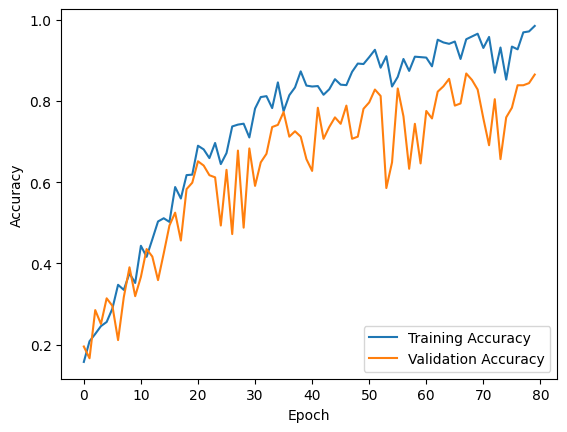

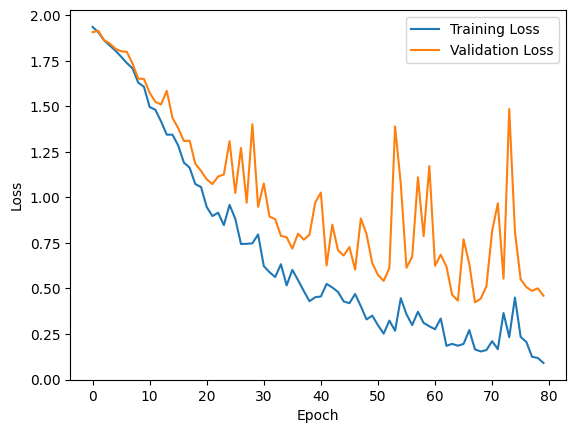

In [167]:
# 정확도 그래프
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# 손실 그래프
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

## 테스트

### 데이터 가져오기

In [204]:
import pandas as pd

json_file_path = 'CNNect.data(full).json'

df = read_json_to_df(json_file_path)
# df.drop(columns=df.columns.difference(['full_script', 'video_id', 'title']), inplace=True)

if df is not None:
    print(df)

                                        _id     video_id  \
0      {'$oid': '65f718aa887cecf903ef13f0'}  jsxI0QjxJs8   
1      {'$oid': '65f718aa887cecf903ef13f2'}  rGMqBoF3hkU   
2      {'$oid': '65f718aa887cecf903ef13f3'}  2keAv3W3edw   
3      {'$oid': '65f718aa887cecf903ef13f4'}  dyXBfjwu4fA   
4      {'$oid': '65f718aa887cecf903ef13f5'}  7ozPfsLRxZw   
...                                     ...          ...   
35387  {'$oid': '65f73436887cecf903f0db5d'}  HGQct9tFpm0   
35388  {'$oid': '65f73436887cecf903f0db60'}  nLtnU20ZVO0   
35389  {'$oid': '65f73436887cecf903f0db61'}  vmxgRP7OZf8   
35390  {'$oid': '65f73438887cecf903f0db71'}  34-cY8wIrcw   
35391  {'$oid': '65f739d3887cecf903f12dcb'}  -aWdR1z1HfI   

                                             full_script  \
0      Here with me now is Israeli Prime Minister Ben...   
1      After severe storms and tornadoes hit multiple...   
2      As you know, it's been a tough week for the pr...   
3      Are looking at images seen earli

### 전처리 : 토큰화 및 패딩

In [205]:
get_longest_word_count(df['full_script'].tolist())
get_middlelong_word_count(df['full_script'].tolist())

가장 긴 문장의 단어 수: 24484
중간 길이의 문장의 단어 수: 387


In [186]:
print(category_mapping)

{'politics': 0, 'business': 1, 'sports': 2, 'style': 3, 'entertainment': 4, 'health': 5, 'travel': 6}


In [206]:
df['cleaned_script'] = df.full_script.apply(make_lower_case)
df['cleaned_script'] = df.cleaned_script.apply(remove_punctuation)

df['cleaned_script']

0        here with me now is israeli prime minister ben...
1        after severe storms and tornadoes hit multiple...
2        as you know it s been a tough week for the pro...
3        are looking at images seen earlier in trenton ...
4        m john better but pounds had this is cnn what ...
                               ...                        
35387    calls for blood are getting louder and louder ...
35388    of you some information about what we re doing...
35389    mostly a clandestine presence operated by the ...
35390    and helping their dreams to come true and we r...
35391    bjbjlulu joining us by telephone tonight is pi...
Name: cleaned_script, Length: 35392, dtype: object

In [ ]:
# pip install tabulate

In [173]:
from tabulate import tabulate

In [207]:
max_length = 3000
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_script'])
X_sequences = tokenizer.texts_to_sequences(df['cleaned_script'])
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding='post', truncating='post')

# 예측 수행
predictions = model.predict(X_padded)

# 예측 결과를 DataFrame에 적용
df['category_id'] = [np.argmax(pred) for pred in predictions]


1106/1106 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step


In [210]:
# 숫자에서 문자로 카테고리 변환을 위한 딕셔너리 생성
category_reverse_mapping = {index: category for category, index in category_mapping.items()}

# 예측 결과를 문자로 변환하여 새로운 열에 추가
df['predicted_category'] = df['category_id'].map(category_reverse_mapping)

In [211]:
print(tabulate(df[['video_id', 'predicted_category']][:100], headers='keys', tablefmt='pretty'))

+----+-------------+--------------------+
|    |  video_id   | predicted_category |
+----+-------------+--------------------+
| 0  | jsxI0QjxJs8 |      politics      |
| 1  | rGMqBoF3hkU |       sports       |
| 2  | 2keAv3W3edw |       sports       |
| 3  | dyXBfjwu4fA |       sports       |
| 4  | 7ozPfsLRxZw |      business      |
| 5  | Q1KbKe2eJaY |      politics      |
| 6  | dwjJS2p0w4A |       sports       |
| 7  | ibBNhhhTgMk |      business      |
| 8  | dvccoSqV8NE |      business      |
| 9  | 3eh5nCYG7k8 |       sports       |
| 10 | xqTaUR0UsqI |       sports       |
| 11 | NsqlJ9HnuLc |      politics      |
| 12 | xifyyLL500w |       sports       |
| 13 | 1TijdSYu6Kc |       sports       |
| 14 | aEDLxivVPTY |       sports       |
| 15 | XrICFSK3rA8 |       sports       |
| 16 | 9BQT7odQwgw |      business      |
| 17 | dRFXqGSMRPY |      politics      |
| 18 | Bl0Imc6nDrk |       sports       |
| 19 | oGxqtJY48k0 |       sports       |
| 20 | FtE414zkSX0 |       sports 

In [212]:
prediction_counts = df['predicted_category'].value_counts()
print(prediction_counts)

predicted_category
politics         16339
sports            7677
entertainment     5850
style             3922
business          1428
travel             165
health              11
Name: count, dtype: int64


In [213]:
df.columns

Index(['_id', 'video_id', 'full_script', 'senteceList', 'category_name',
       'video_date', 'video_name', 'video_thumbnail', 'cleaned_script',
       'category_id', 'predicted_category'],
      dtype='object')

In [214]:
# 필요없는 컬럼 제거
columns_to_drop = ['cleaned_script', 'predicted_category', 'category_name']
df = df.drop(columns=columns_to_drop)

# JSON 파일로 저장
df.to_json('addCategory.json', orient='records')